In [56]:
import pandas as pd
import json
from pathlib import Path
import re
import sys
sys.path.insert(0, '/home/sagemaker-user/compliance')
from compliance_utils import print_color

FOLDER_HOME: Path = Path('/home/sagemaker-user')
FOLDER_JUDGED_SCENARIOS: Path = FOLDER_HOME / 'data/judged_scenarios/'
FOLDER_JUDGED_SCENARIOS_CSV: Path = FOLDER_JUDGED_SCENARIOS / 'csv/'

In [40]:
def parse_filename(filename):
    parts = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '').split('-')
    complexity = parts[0]
    model = '-'.join(parts[3:-1])
    temp = parts[-1].replace('temp', '')
    
    print(f"Model: {model}")
    print(f"Temp: {temp}")
    print(f"Scenario Complexity: {complexity}")

In [47]:
def analyze_scenarios_in_json_files(folder_path):
    folder = Path(folder_path)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
                
            print_color(f"\n\n{json_file.name}", 'cyan')
            parse_filename(json_file.name)
            print_color(f"Total={len(scenarios)}", 'blue')
            print("=" * 80)
            
            # Confusion matrix counters
            tp = fp = tn = fn = 0
            
            for scenario in scenarios:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant and judged_compliant:
                    tp += 1
                elif not is_compliant and judged_compliant:
                    fp += 1
                elif not is_compliant and not judged_compliant:
                    tn += 1
                elif is_compliant and not judged_compliant:
                    fn += 1
            
            
            print("Confusion Matrix:")
            print("                Predicted")
            print("Actual      Compliant  Non-Compliant")
            print("Compliant      " + f"\033[92m{tp:4d}\033[0m" + "       " + f"\033[95m{fn:4d}\033[0m")
            print("Non-Compliant  " + f"\033[95m{fp:4d}\033[0m" + "       " + f"\033[92m{tn:4d}\033[0m")

            print(f"% False Positive: {(fp/len(scenarios)):.1%}       % False Negative: {(fn/len(scenarios)):.1%}")

            print("=" * 80)
            
        except Exception as e:
            print_color(f"{json_file.name}: Error - {e}", 'red')


In [42]:
def json_to_csv(json_file: Path, csv_file_path: Path):
    """Convert JSON file to CSV"""
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Handle both formats: {"scenarios": [...]} or [...]
    scenarios = data.get('scenarios', data) if isinstance(data, dict) else data
    
    df = pd.DataFrame(scenarios)
    df.to_csv(csv_file_path, index=False)
    print(f"Converted {json_file_path} to {csv_file_path}")
    
    return csv_file_path


In [57]:
def concatenate_csv_files(input_path: Path, output_file_path: Path):
    """
    Concatenate all CSV files in a directory into one CSV file
    Usage: concatenate_csv_files(Path("/path/to/csv/files"), Path("/path/to/combined_output.csv"))
    """
    csv_files = list(input_path.glob("*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_path}")
        return
    
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dfs.append(df)
        print(f"Added {csv_file.name} ({len(df)} rows)")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv(output_file_path, index=False)
    
    print(f"Concatenated {len(csv_files)} files into {output_file_path} ({len(combined_df)} total rows)")
    return output_file_path


JSON Error in judged_scenarios_batch-scenarios-4-policies-each-claude_opus_4_5-temp0.0.json: Expecting ',' delimiter: line 1 column 59753 (char 59752)


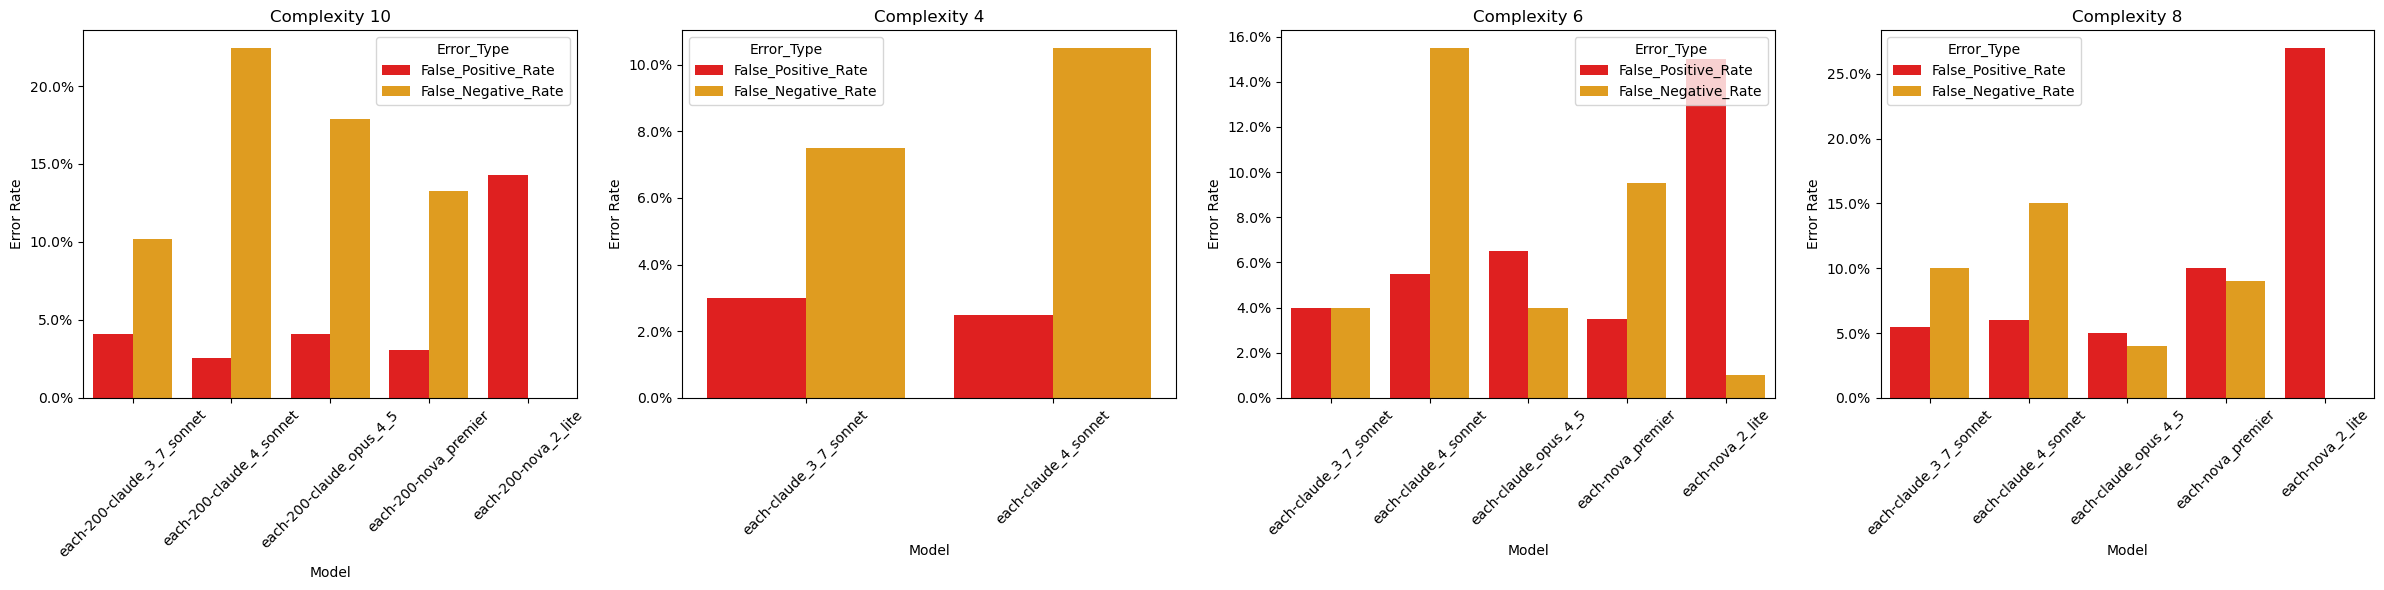

In [55]:
def collect_metrics_data(folder_path):
    results = []
    folder = Path(folder_path)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
        except json.JSONDecodeError as e:
            print(f"JSON Error in {json_file.name}: {e}")
            continue
        
        # Parse filename - extract complexity from scenario filename
        parts = json_file.name.replace('judged_scenarios_batch-', '').replace('.json', '').split('-')
        
        # Extract complexity from "scenarios-X-policies-each" pattern
        complexity_match = re.search(r'scenarios-(\d+)-policies-each', json_file.name)
        complexity = complexity_match.group(1) if complexity_match else 'unknown'
        
        model = '-'.join(parts[3:-1])
        
        # Calculate metrics
        tp = fp = tn = fn = 0
        for scenario in scenarios:
            is_compliant = scenario.get('is-compliant')
            judged_compliant = scenario.get('judged-compliant')
            
            if is_compliant and judged_compliant: tp += 1
            elif not is_compliant and judged_compliant: fp += 1
            elif not is_compliant and not judged_compliant: tn += 1
            elif is_compliant and not judged_compliant: fn += 1
        
        results.append({
            'Model': model,
            'Complexity': complexity,
            'False_Positive_Rate': fp/len(scenarios),
            'False_Negative_Rate': fn/len(scenarios)
        })
    
    return pd.DataFrame(results)



import matplotlib.pyplot as plt
import seaborn as sns

# Create separate charts by complexity
df = collect_metrics_data("/home/sagemaker-user/data/judged_scenarios")
df_melted = df.melt(id_vars=['Model', 'Complexity'], 
                    value_vars=['False_Positive_Rate', 'False_Negative_Rate'],
                    var_name='Error_Type', value_name='Rate')

complexities = sorted(df['Complexity'].unique())
n_complexities = len(complexities)

fig, axes = plt.subplots(1, n_complexities, figsize=(6*n_complexities, 6))
if n_complexities == 1:
    axes = [axes]

for i, complexity in enumerate(complexities):
    data_subset = df_melted[df_melted['Complexity'] == complexity]
    
    sns.barplot(data=data_subset, x='Model', y='Rate', hue='Error_Type', 
                palette=['red', 'orange'], ax=axes[i])
    
    axes[i].set_title(f'Complexity {complexity}')
    axes[i].set_ylabel('Error Rate')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.tight_layout()
plt.show()


In [70]:
import pandas as pd
import json
from pathlib import Path
import re
from collections import defaultdict

def extract_model_from_filename(filename):
    """Extract model name from filename"""
    name = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '')
    parts = name.split('-')
    policies_idx = next(i for i, part in enumerate(parts) if part == 'policies')
    model_parts = parts[policies_idx+2:-1]
    model_name = '_'.join(model_parts)
    # Remove "200_" prefix if present
    if model_name.startswith('200_'):
        model_name = model_name[4:]
    return model_name

def extract_complexity_from_filename(filename):
    """Extract scenario complexity (number of policies) from filename"""
    match = re.search(r'scenarios-(\d+)-policies-each', filename)
    return int(match.group(1)) if match else None

def load_scenario_data(folder_path):
    """Load all scenario data grouped by complexity"""
    folder = Path(folder_path)
    data_by_complexity = defaultdict(dict)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
            
            complexity = extract_complexity_from_filename(json_file.name)
            model = extract_model_from_filename(json_file.name)
            
            if complexity and model:
                data_by_complexity[complexity][model] = scenarios
                
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    return data_by_complexity

def create_misjudged_table(scenario_data):
    """Create table of misjudged scenarios for a given complexity"""
    models = list(scenario_data.keys())
    first_model = models[0]
    scenario_ids = [s['scenario-id'] for s in scenario_data[first_model]]
    
    misjudged_scenarios = []
    
    for scenario_id in scenario_ids:
        misjudged_by = []
        
        for model in models:
            scenario = next((s for s in scenario_data[model] if s['scenario-id'] == scenario_id), None)
            if scenario:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant != judged_compliant:
                    misjudged_by.append(model)
        
        if misjudged_by:
            misjudged_scenarios.append((scenario_id, misjudged_by))
    
    if not misjudged_scenarios:
        return pd.DataFrame(), len(scenario_ids)
    
    table_data = []
    for scenario_id, misjudged_models in misjudged_scenarios:
        row = {'scenario-id': scenario_id}
        for model in models:
            row[model] = 'X' if model in misjudged_models else ''
        row['Count'] = len(misjudged_models)
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    
    # Rename columns to include statistics
    total_scenarios = len(scenario_ids)
    for model in models:
        model_misjudged = (df[model] == 'X').sum()
        model_percentage = (model_misjudged / total_scenarios) * 100
        new_col_name = f"{model}<br>{model_misjudged}/{total_scenarios} = {model_percentage:.1f}%"
        df = df.rename(columns={model: new_col_name})
    
    return df, total_scenarios

# Load data
folder_path = '/home/sagemaker-user/data/judged_scenarios'
data_by_complexity = load_scenario_data(folder_path)

# Generate markdown output
markdown_output = "# LLM Compliance Evaluation - Misjudged Scenarios Analysis\n\n"

for complexity in sorted(data_by_complexity.keys()):
    table, total_scenarios = create_misjudged_table(data_by_complexity[complexity])
    
    markdown_output += f"## Scenario Set: {complexity} Policies Each\n\n"
    
    if table.empty:
        markdown_output += "✅ **No misjudged scenarios found.**\n\n"
    else:
        misjudged_count = len(table)
        percentage = (misjudged_count / total_scenarios) * 100
        markdown_output += f"**Misjudged scenarios:** {misjudged_count}/{total_scenarios} = {percentage:.1f}%\n\n"
        
        # Convert DataFrame to markdown table
        markdown_output += table.to_markdown(index=False) + "\n\n"
        
        # Summary
        count_summary = table['Count'].value_counts().sort_index()
        markdown_output += "### Summary\n\n"
        for count_val, freq in count_summary.items():
            markdown_output += f"- {freq} scenarios misjudged by {count_val} model(s)\n"
        markdown_output += "\n"

print(markdown_output)


# LLM Compliance Evaluation - Misjudged Scenarios Analysis

## Scenario Set: 4 Policies Each

**Misjudged scenarios:** 69/200 = 34.5%

| scenario-id     | claude_3_7_sonnet<br>21/200 = 10.5%   | claude_4_sonnet<br>26/200 = 13.0%   | claude_opus_4_5<br>18/200 = 9.0%   | nova_premier<br>26/200 = 13.0%   | nova_2_lite<br>23/200 = 11.5%   |   Count |
|:----------------|:--------------------------------------|:------------------------------------|:-----------------------------------|:---------------------------------|:--------------------------------|--------:|
| scenario-id-2   |                                       | X                                   |                                    |                                  |                                 |       1 |
| scenario-id-3   |                                       |                                     |                                    | X                                |                                 |       1 |
| scenari

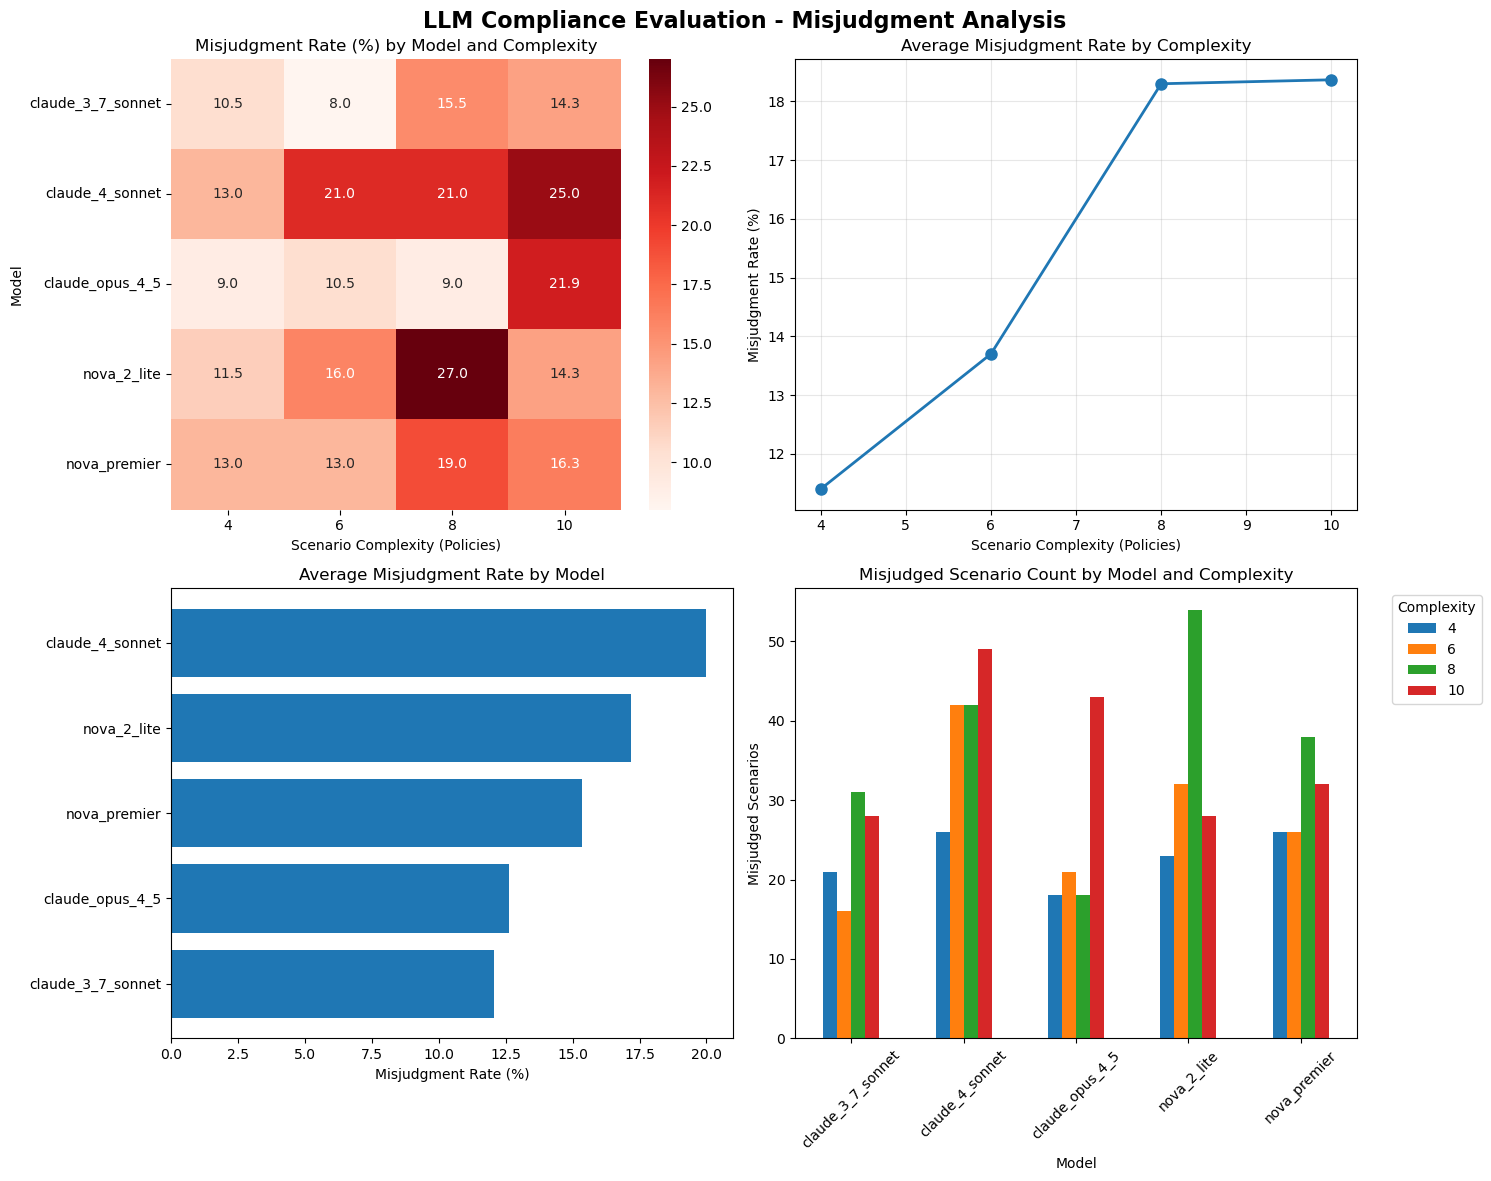


=== SUMMARY STATISTICS ===
Best performing model (lowest avg misjudgment): claude_3_7_sonnet (12.1%)
Worst performing model (highest avg misjudgment): claude_4_sonnet (20.0%)
Complexity with highest misjudgment rate: 10 policies (18.4%)
Complexity with lowest misjudgment rate: 4 policies (11.4%)


In [67]:
import pandas as pd
import json
from pathlib import Path
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def extract_model_from_filename(filename):
    name = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '')
    parts = name.split('-')
    policies_idx = next(i for i, part in enumerate(parts) if part == 'policies')
    model_parts = parts[policies_idx+2:-1]
    model_name = '_'.join(model_parts)
    # Remove "200_" prefix if present
    if model_name.startswith('200_'):
        model_name = model_name[4:]
    return model_name

def extract_complexity_from_filename(filename):
    match = re.search(r'scenarios-(\d+)-policies-each', filename)
    return int(match.group(1)) if match else None

def load_scenario_data(folder_path):
    folder = Path(folder_path)
    data_by_complexity = defaultdict(dict)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
            
            complexity = extract_complexity_from_filename(json_file.name)
            model = extract_model_from_filename(json_file.name)
            
            if complexity and model:
                data_by_complexity[complexity][model] = scenarios
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    return data_by_complexity

def calculate_misjudgment_stats(data_by_complexity):
    stats = []
    
    for complexity, scenario_data in data_by_complexity.items():
        models = list(scenario_data.keys())
        first_model = models[0]
        scenario_ids = [s['scenario-id'] for s in scenario_data[first_model]]
        total_scenarios = len(scenario_ids)
        
        for model in models:
            misjudged_count = 0
            for scenario_id in scenario_ids:
                scenario = next((s for s in scenario_data[model] if s['scenario-id'] == scenario_id), None)
                if scenario:
                    is_compliant = scenario.get('is-compliant')
                    judged_compliant = scenario.get('judged-compliant')
                    if is_compliant != judged_compliant:
                        misjudged_count += 1
            
            misjudgment_rate = (misjudged_count / total_scenarios) * 100
            stats.append({
                'complexity': complexity,
                'model': model,
                'misjudged_count': misjudged_count,
                'total_scenarios': total_scenarios,
                'misjudgment_rate': misjudgment_rate
            })
    
    return pd.DataFrame(stats)

# Load data and calculate statistics
folder_path = '/home/sagemaker-user/data/judged_scenarios'
data_by_complexity = load_scenario_data(folder_path)
stats_df = calculate_misjudgment_stats(data_by_complexity)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('LLM Compliance Evaluation - Misjudgment Analysis', fontsize=16, fontweight='bold')

# 1. Misjudgment Rate by Model and Complexity (Heatmap)
pivot_df = stats_df.pivot(index='model', columns='complexity', values='misjudgment_rate')
sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Misjudgment Rate (%) by Model and Complexity')
axes[0,0].set_xlabel('Scenario Complexity (Policies)')
axes[0,0].set_ylabel('Model')

# 2. Misjudgment Rate by Complexity (Line Plot)
complexity_avg = stats_df.groupby('complexity')['misjudgment_rate'].mean()
axes[0,1].plot(complexity_avg.index, complexity_avg.values, marker='o', linewidth=2, markersize=8)
axes[0,1].set_title('Average Misjudgment Rate by Complexity')
axes[0,1].set_xlabel('Scenario Complexity (Policies)')
axes[0,1].set_ylabel('Misjudgment Rate (%)')
axes[0,1].grid(True, alpha=0.3)

# 3. Misjudgment Rate by Model (Bar Chart)
model_avg = stats_df.groupby('model')['misjudgment_rate'].mean().sort_values(ascending=True)
axes[1,0].barh(range(len(model_avg)), model_avg.values)
axes[1,0].set_yticks(range(len(model_avg)))
axes[1,0].set_yticklabels(model_avg.index)
axes[1,0].set_title('Average Misjudgment Rate by Model')
axes[1,0].set_xlabel('Misjudgment Rate (%)')

# 4. Misjudgment Count by Model and Complexity (Grouped Bar)
pivot_count = stats_df.pivot(index='model', columns='complexity', values='misjudged_count')
pivot_count.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Misjudged Scenario Count by Model and Complexity')
axes[1,1].set_xlabel('Model')
axes[1,1].set_ylabel('Misjudged Scenarios')
axes[1,1].legend(title='Complexity', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Best performing model (lowest avg misjudgment): {model_avg.index[0]} ({model_avg.iloc[0]:.1f}%)")
print(f"Worst performing model (highest avg misjudgment): {model_avg.index[-1]} ({model_avg.iloc[-1]:.1f}%)")
print(f"Complexity with highest misjudgment rate: {complexity_avg.idxmax()} policies ({complexity_avg.max():.1f}%)")
print(f"Complexity with lowest misjudgment rate: {complexity_avg.idxmin()} policies ({complexity_avg.min():.1f}%)")


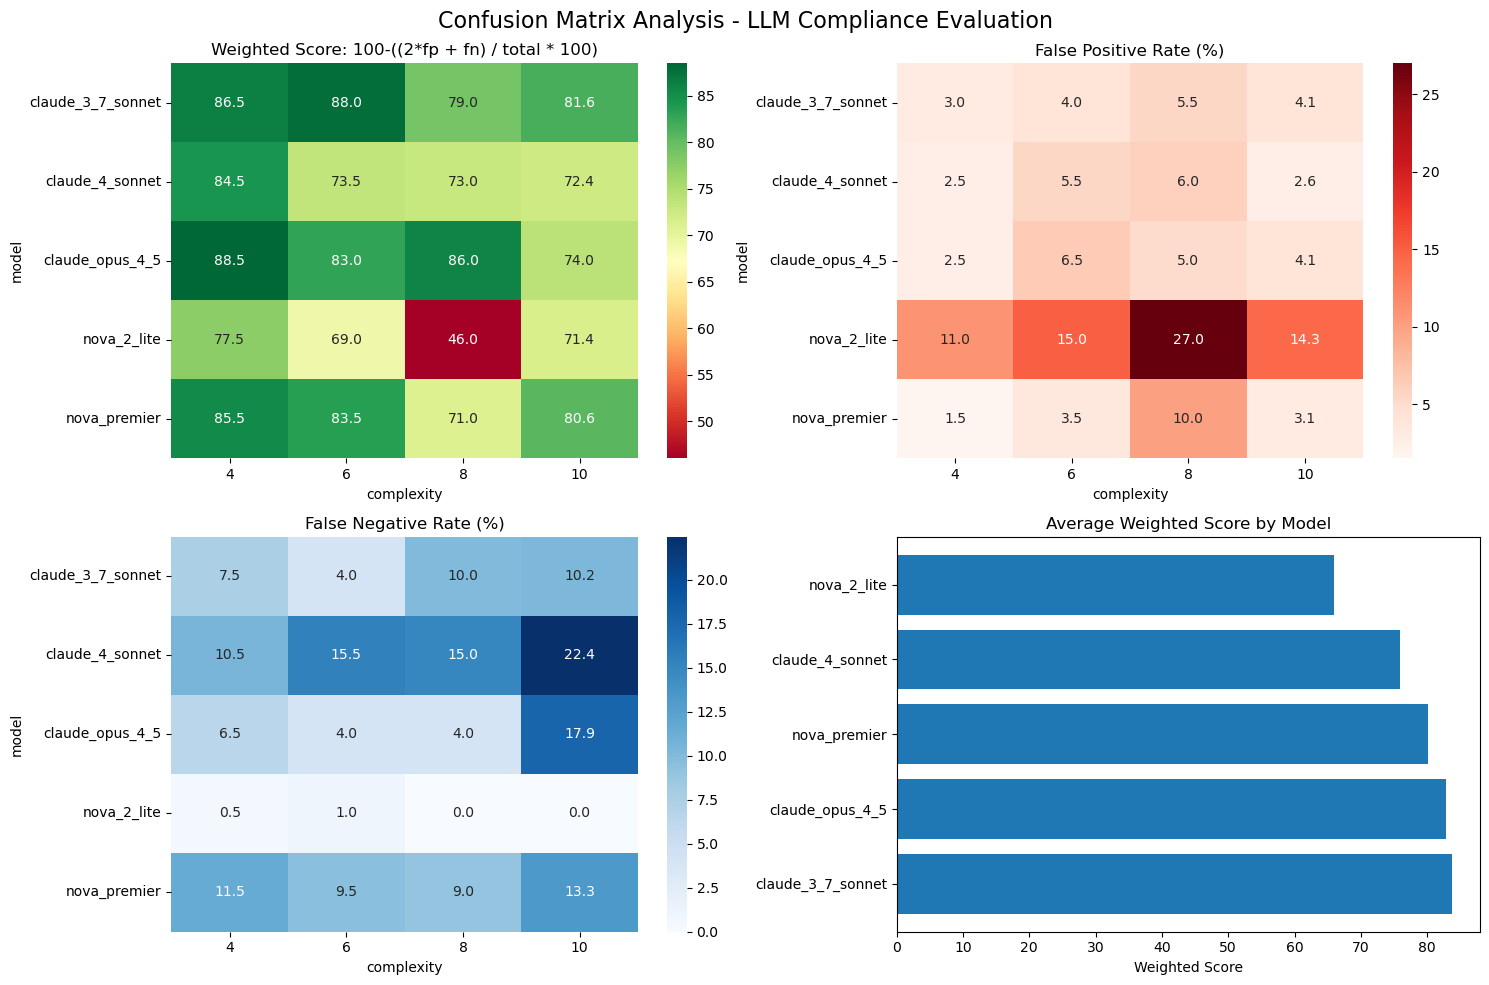


=== WEIGHTED SCORING SUMMARY ===
(False Positives penalized 2x more than False Negatives)
1. claude_3_7_sonnet: 83.8
2. claude_opus_4_5: 82.9
3. nova_premier: 80.2
4. claude_4_sonnet: 75.9
5. nova_2_lite: 66.0


In [69]:
import pandas as pd
import json
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def extract_model_from_filename(filename):
    name = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '')
    parts = name.split('-')
    policies_idx = next(i for i, part in enumerate(parts) if part == 'policies')
    model_parts = parts[policies_idx+2:-1]
    model_name = '_'.join(model_parts)
    if model_name.startswith('200_'):
        model_name = model_name[4:]
    return model_name

def extract_complexity_from_filename(filename):
    match = re.search(r'scenarios-(\d+)-policies-each', filename)
    return int(match.group(1)) if match else None

def analyze_scenarios_in_json_files(folder_path):
    folder = Path(folder_path)
    results = []
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
            
            model = extract_model_from_filename(json_file.name)
            complexity = extract_complexity_from_filename(json_file.name)
            
            # Confusion matrix counters
            tp = fp = tn = fn = 0
            
            for scenario in scenarios:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant and judged_compliant:
                    tp += 1
                elif not is_compliant and judged_compliant:
                    fp += 1
                elif not is_compliant and not judged_compliant:
                    tn += 1
                elif is_compliant and not judged_compliant:
                    fn += 1
            
            # Calculate weighted score (FP penalized 2x more than FN)
            total = len(scenarios)
            weighted_score = 100 - ((2 * fp + fn) / total * 100)
            
            results.append({
                'model': model,
                'complexity': complexity,
                'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
                'total': total,
                'fp_rate': fp/total*100,
                'fn_rate': fn/total*100,
                'weighted_score': weighted_score
            })
            
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    # Create visualizations
    df = pd.DataFrame(results)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Confusion Matrix Analysis - LLM Compliance Evaluation', fontsize=16)
    
    # 1. Weighted Score Heatmap
    pivot_score = df.pivot(index='model', columns='complexity', values='weighted_score')
    sns.heatmap(pivot_score, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[0,0])
    axes[0,0].set_title('Weighted Score: 100-((2*fp + fn) / total * 100)')
    
    # 2. False Positive Rate
    pivot_fp = df.pivot(index='model', columns='complexity', values='fp_rate')
    sns.heatmap(pivot_fp, annot=True, fmt='.1f', cmap='Reds', ax=axes[0,1])
    axes[0,1].set_title('False Positive Rate (%)')
    
    # 3. False Negative Rate
    pivot_fn = df.pivot(index='model', columns='complexity', values='fn_rate')
    sns.heatmap(pivot_fn, annot=True, fmt='.1f', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('False Negative Rate (%)')
    
    # 4. Model Performance Ranking
    model_scores = df.groupby('model')['weighted_score'].mean().sort_values(ascending=False)
    axes[1,1].barh(range(len(model_scores)), model_scores.values)
    axes[1,1].set_yticks(range(len(model_scores)))
    axes[1,1].set_yticklabels(model_scores.index)
    axes[1,1].set_title('Average Weighted Score by Model')
    axes[1,1].set_xlabel('Weighted Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n=== WEIGHTED SCORING SUMMARY ===")
    print("(False Positives penalized 2x more than False Negatives)")
    for i, (model, score) in enumerate(model_scores.items(), 1):
        print(f"{i}. {model}: {score:.1f}")

# Run analysis
folder_path = '/home/sagemaker-user/data/judged_scenarios'
analyze_scenarios_in_json_files(folder_path)


In [58]:
def main():

    analyze_scenarios_in_json_files("/home/sagemaker-user/data/judged_scenarios")
    
    # for json_file in Path(FOLDER_JUDGED_SCENARIOS).glob("*.json"):
    #     json_to_csv(json_file = json_file, csv_file_path = FOLDER_JUDGED_SCENARIOS_CSV)
    
    # concatenate_csv_files(input_path=FOLDER_JUDGED_SCENARIOS_CSV, output_file_path=FOLDER_JUDGED_SCENARIOS_CSV / "combined_output.csv")

In [59]:
main()



judged_scenarios_batch-scenarios-8-policies-each-claude_3_7_sonnet-temp0.1.json
Model: claude_3_7_sonnet
Temp: 0.1
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        80         20
Non-Compliant    11         89
% False Positive: 5.5%       % False Negative: 10.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_4_sonnet-temp0.0.json
Model: claude_4_sonnet
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        70         30
Non-Compliant    12         88
% False Positive: 6.0%       % False Negative: 15.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_opus_4_5-temp0.0.json
Model: claude_opus_4_5
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        92          8
Non-Compliant    10         90
% False Positive: 5.0% 